<a href="https://colab.research.google.com/github/ebamberg/research-projects-ml/blob/main/Image_Generation/examples_diffusers_train_a_diffuser_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Diffuser Model
## Training Dataset

In [1]:
!pip install diffusers[training] --quiet
# !pip install --upgrade  diffusers[training] accelerate transformers datasets safetensors --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 18.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 18.0.0 which is incompatible.


README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})


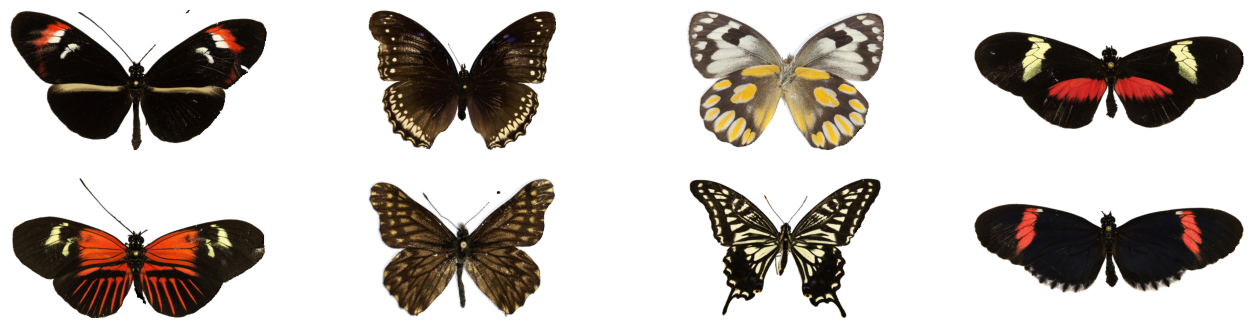

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader


image_size=128
batch_size=16

dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

fig, axs = plt.subplots(2, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:10]["image"]):
    axs[i//4-1][i-(i//4)*4].imshow(image)
    axs[i//4-1][i-(i//4)*4].set_axis_off()
fig.show()


# resize all images to the same size
# the transform function receives a batch of rows from dataset
# in torchvision we can chain transform operations by creating a compose.
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),             # gives us virtually more examples for training
        transforms.ToTensor(),                         # we need a tensor image (ch,w,h) instead of a PIL image (w,h,c)
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(batch):
    # from the batch use column "image" and covert to RGB format
    images = [preprocess(image.convert("RGB")) for image in batch["image"]]
    # return a new dict that only  contains the batch of images
    return {"images": images}

dataset.set_transform(transform)


train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print (dataset)

In [3]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## add noise to an image using a scheduler

In [4]:

import torch
from PIL import Image
from diffusers import DDPMScheduler

sample_image = dataset[0]["images"].unsqueeze(0)
print(sample_image.shape)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

display_sample(noisy_image)


torch.Size([1, 3, 128, 128])


NameError: name 'display_sample' is not defined

The training objective of the model is to predict the noise added to the image

In [5]:
from torch.nn.functional import mse_loss

noise_residual = model(noisy_image, timesteps).sample
loss = mse_loss(noise_residual, noise)

print (loss)

tensor(1.0995, grad_fn=<MseLossBackward0>)


ok no create an optimizer and a leraning rate scheduler and build a training loop

In [ ]:


from torch.nn.functional import mse_loss
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler
from datasets import load_dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from safetensors.torch import save_model


image_size=128
batch_size=16
eval_batch_size = 16  # how many images to sample during evaluation
num_epochs = 50
gradient_accumulation_steps = 1
learning_rate = 1e-4
lr_warmup_steps = 500

dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

fig, axs = plt.subplots(2, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:10]["image"]):
    axs[i//4-1][i-(i//4)*4].imshow(image)
    axs[i//4-1][i-(i//4)*4].set_axis_off()
fig.show()


# resize all images to the same size
# the transform function receives a batch of rows from dataset
# in torchvision we can chain transform operations by creating a compose.
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),             # gives us virtually more examples for training
        transforms.ToTensor(),                         # we need a tensor image (ch,w,h) instead of a PIL image (w,h,c)
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(batch):
    # from the batch use column "image" and covert to RGB format
    images = [preprocess(image.convert("RGB")) for image in batch["image"]]
    # return a new dict that only  contains the batch of images
    return {"images": images}

dataset.set_transform(transform)


train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * num_epochs),
)


def save_eval_images(epoch, model, noise_scheduler):
    pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=16,
        generator=torch.Generator(device='cpu').manual_seed(1234), # Use a separate torch generator to avoid rewinding the random state of the main training loop
        num_inference_steps =1000
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join("/content/", "sample_data")
    print (f"save images to {test_dir}")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")
    save_model(model,f"{test_dir}/model_{epoch:04d}")


model=model.to("cuda")

progress_bar = tqdm(total=len(train_dataloader)*num_epochs)
progress_bar.set_description(f"Epochs {num_epochs} ")

for epoch in range(num_epochs):
        model.train(True)
        for step, batch in enumerate(train_dataloader):
            images = batch["images"].to("cuda")
            batchsize = images.shape[0]
            # create a new noise image with the same size as the training image
            noise = torch.randn(images.shape, device="cuda")
            # create a random list of timesteps for every image in the batch to train the model on
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (batchsize,), device="cuda",
                dtype=torch.int64
            )
            # add noise to all the images
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = mse_loss(noise_pred, noise)
            loss.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(batchsize)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": step, "epoch": epoch}
            progress_bar.set_postfix(**logs)
        model.eval()
        if (epoch+1) % 5 == 0:
            save_eval_images(epoch, model, noise_scheduler)

progress_bar.close()

#

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.8 MB/s eta 0:00:00


Repo card metadata block was not found. Setting CardData to empty.
Epochs 50 :   6%|▌         | 176/3150 [00:14<03:35, 13.79it/s, epoch=0, loss=1.06, lr=2.2e-6, step=10]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')